In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import regex as re
import math
from collections import defaultdict
import pytz
import shin

from scipy.stats import norm
from scipy.optimize import brentq
from scipy.special import expit, logit

from rapidfuzz.fuzz import ratio

To do:
- Filter out duplicates; only keep most recent
    - Actual data testing will require end results anyways
- Figure out whether edge_df, tp/sl, ev, ev_distribution, filtered_df are being computed correctly

In [13]:
date = '2026-01-30'
sport = 'NCAAMB' #NCAAMB, NCAAWB, NBA, ATP, WTA, MLB
market = "GAME" #GAME, SPREAD, TOTAL

if sport == 'ATP' or sport == 'WTA':
    market = 'MATCH'

In [14]:
#betus good for nba, pinnacle, betonline best for everything, fanduel pretty good

df = pd.read_csv(f"../data_collection/kalshi_data/kalshi_logs/{date}/joined_{date}.csv")
df = df[df['match_status'] == 'matched']
df = df[df['ticker'].str.startswith(f"KX{sport}{market}", na=False)]
df

,timestamp,ticker,title,status,market_type,event_start_time,yes_bid,yes_ask,no_bid,no_ask,...,dollar_open_interest,devig_prob,oddsapi_game_id,oddsapi_team,oddsapi_point,oddsapi_home_team,oddsapi_away_team,oddsapi_start_time,oddsapi_fetch_timestamp,match_status
2,2026-01-29T20:44:13.691300-05:00,KXNCAAMBGAME-26JAN30NKUDET-NKU,Northern Kentucky at Detroit Mercy Winner?,active,binary,NaN,0.67,0.71,0.29,0.33,...,338.0,0.704022,0ab6bfdc10ca8866a177023ac4f76dda,Northern Kentucky Norse,NaN,Detroit Mercy Titans,Northern Kentucky Norse,2026-01-30 18:00:00 CST,2026-01-29T19:43:05.022871-06:00,matched
10,2026-01-29T20:44:26.691293-05:00,KXNCAAMBGAME-26JAN30DAYSLU-DAY,Dayton at Saint Louis Winner?,active,binary,NaN,0.14,0.17,0.83,0.86,...,2719.0,0.128700,b2911905034891b9e0f6464b2fb95e32,Dayton Flyers,NaN,Saint Louis Billikens,Dayton Flyers,2026-01-30 19:00:00 CST,2026-01-29T19:43:05.022871-06:00,matched
15,2026-01-29T20:44:41.691108-05:00,KXNCAAMBGAME-26JAN30UNLVNEV-NEV,UNLV at Nevada Winner?,active,binary,NaN,0.72,0.79,0.21,0.28,...,39.0,0.783683,397620cf1e14cc87ac0a7abc0c34ed45,Nevada Wolf Pack,NaN,Nevada Wolf Pack,UNLV Rebels,2026-01-30 21:00:00 CST,2026-01-29T19:43:05.022871-06:00,matched
20,2026-01-29T20:44:48.690781-05:00,KXNCAAMBGAME-26JAN30KENTAKR-AKR,Kent St. at Akron Winner?,active,binary,NaN,0.82,0.85,0.15,0.18,...,299.0,0.870268,c1505aaac6d0e5f83caea3d58dbce3ed,Akron Zips,NaN,Akron Zips,Kent State Golden Flashes,2026-01-30 17:00:00 CST,2026-01-29T19:43:05.022871-06:00,matched
28,2026-01-29T20:45:17.691012-05:00,KXNCAAMBGAME-26JAN30IUINYSU-YSU,IU Indy at Youngstown St. Winner?,active,binary,NaN,0.84,0.88,0.12,0.16,...,14.0,0.847042,76ba1b78e52027a0342f2b3d70302fa0,Youngstown St Penguins,NaN,Youngstown St Penguins,IUPUI Jaguars,2026-01-30 17:30:00 CST,2026-01-29T19:43:05.022871-06:00,matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,2026-01-29T21:42:50.250095-05:00,KXNCAAMBGAME-26JAN30MICHMSU-MICH,Michigan at Michigan St. Winner?,active,binary,NaN,0.52,0.53,0.47,0.48,...,25810.0,0.527255,49873c3d111269b4b9eb0a084d9b8fb4,Michigan Wolverines,NaN,Michigan St Spartans,Michigan Wolverines,2026-01-30 19:00:32 CST,2026-01-29T20:15:27.401183-06:00,matched
886,2026-01-29T21:42:58.256400-05:00,KXNCAAMBGAME-26JAN30UNLVNEV-NEV,UNLV at Nevada Winner?,active,binary,NaN,0.72,0.79,0.21,0.28,...,41.0,0.783683,397620cf1e14cc87ac0a7abc0c34ed45,Nevada Wolf Pack,NaN,Nevada Wolf Pack,UNLV Rebels,2026-01-30 21:00:00 CST,2026-01-29T20:15:27.401183-06:00,matched
888,2026-01-29T21:43:01.256093-05:00,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Princeton at Cornell Winner?,active,binary,NaN,0.29,0.36,0.64,0.71,...,146.0,0.288013,13702695bd1dfb71d38102ce8626f736,Princeton Tigers,NaN,Cornell Big Red,Princeton Tigers,2026-01-30 17:00:00 CST,2026-01-29T20:15:27.401183-06:00,matched
896,2026-01-29T21:43:12.250399-05:00,KXNCAAMBGAME-26JAN30NKUDET-NKU,Northern Kentucky at Detroit Mercy Winner?,active,binary,NaN,0.68,0.71,0.29,0.32,...,342.0,0.704022,0ab6bfdc10ca8866a177023ac4f76dda,Northern Kentucky Norse,NaN,Detroit Mercy Titans,Northern Kentucky Norse,2026-01-30 18:00:00 CST,2026-01-29T20:15:27.401183-06:00,matched


In [15]:
EDGE = 0.01
KELLY_UPPERBOUND = 1
BANKROLL = 1000.00
Q1_WEIGHT = 1.00
Q2_WEIGHT = 1.00
Q3_WEIGHT = 1.00
Q4_WEIGHT = 1.00

midprice = (df['yes_bid'] + df['yes_ask']) / 2

edge_df = df.loc[
    (df['devig_prob'] >= df['yes_ask'] + EDGE) |
    ((1 - df['devig_prob']) >= df['no_ask'] + EDGE)
].reset_index(drop=True)

midprice = (edge_df['yes_bid'] + edge_df['yes_ask']) / 2
edge_df['midprice'] = midprice

edge_df = edge_df.loc[((edge_df['devig_prob'] > 0.15) & (edge_df['devig_prob'] < 0.49)) |
                                      ((edge_df['devig_prob'] > 0.51) & (edge_df['devig_prob'] < 0.85)) ]

midprice_yes = (edge_df['yes_bid'] + edge_df['yes_ask']) / 2
midprice_no = (edge_df['no_bid'] + edge_df['no_ask']) / 2

q_yes = edge_df['devig_prob']
q_no = 1 - edge_df['devig_prob'] 

#edge_winners_df['edge'] = np.where(q_yes > midprice_yes, q_yes - midprice_yes, q_no - midprice_no)
edge_df['edge'] = np.where(q_yes > midprice_yes, q_yes - edge_df['yes_ask'], q_no - edge_df['no_ask'])

edge_df['devig_prob'] = np.where(q_yes > midprice_yes, edge_df['devig_prob'], 1 - edge_df['devig_prob'])

edge_df['bid'] = np.where(q_yes > midprice_yes, edge_df['yes_bid'], edge_df['no_bid'])
edge_df['ask'] = np.where(q_yes > midprice_yes, edge_df['yes_ask'], edge_df['no_ask'])

edge_df['buy_direction'] = np.where(q_yes > midprice_yes, "yes", "no")
edge_df.reset_index(drop=True, inplace=True)

assert (len(edge_df) != 0), f"No bets on {sport} today"

In [16]:
edge_df

,timestamp,ticker,title,status,market_type,event_start_time,yes_bid,yes_ask,no_bid,no_ask,...,oddsapi_home_team,oddsapi_away_team,oddsapi_start_time,oddsapi_fetch_timestamp,match_status,midprice,edge,bid,ask,buy_direction
0,2026-01-29T20:48:07.690486-05:00,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Princeton at Cornell Winner?,active,binary,NaN,0.3,0.36,0.64,0.7,...,Cornell Big Red,Princeton Tigers,2026-01-30 17:00:00 CST,2026-01-29T19:43:05.022871-06:00,matched,0.330,0.011987,0.64,0.7,no
1,2026-01-29T21:03:44.781257-05:00,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Princeton at Cornell Winner?,active,binary,NaN,0.3,0.36,0.64,0.7,...,Cornell Big Red,Princeton Tigers,2026-01-30 17:00:00 CST,2026-01-29T19:43:05.022871-06:00,matched,0.330,0.011987,0.64,0.7,no
2,2026-01-29T21:10:59.702965-05:00,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Princeton at Cornell Winner?,active,binary,NaN,0.3,0.36,0.64,0.7,...,Cornell Big Red,Princeton Tigers,2026-01-30 17:00:00 CST,2026-01-29T19:43:05.022871-06:00,matched,0.330,0.011987,0.64,0.7,no
3,2026-01-29T21:18:15.270061-05:00,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Princeton at Cornell Winner?,active,binary,NaN,0.3,0.36,0.64,0.7,...,Cornell Big Red,Princeton Tigers,2026-01-30 17:00:00 CST,2026-01-29T20:15:27.401183-06:00,matched,0.330,0.011987,0.64,0.7,no
4,2026-01-29T21:29:25.358148-05:00,KXNCAAMBGAME-26JAN30FAIRIONA-IONA,Fairfield at Iona Winner?,active,binary,NaN,0.6,0.61,0.39,0.4,...,Iona Gaels,Fairfield Stags,2026-01-30 18:00:00 CST,2026-01-29T20:15:27.401183-06:00,matched,0.605,0.016096,0.39,0.4,no
5,2026-01-29T21:29:33.260997-05:00,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Princeton at Cornell Winner?,active,binary,NaN,0.3,0.36,0.64,0.7,...,Cornell Big Red,Princeton Tigers,2026-01-30 17:00:00 CST,2026-01-29T20:15:27.401183-06:00,matched,0.330,0.011987,0.64,0.7,no
6,2026-01-29T21:36:31.254716-05:00,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Princeton at Cornell Winner?,active,binary,NaN,0.3,0.36,0.64,0.7,...,Cornell Big Red,Princeton Tigers,2026-01-30 17:00:00 CST,2026-01-29T20:15:27.401183-06:00,matched,0.330,0.011987,0.64,0.7,no


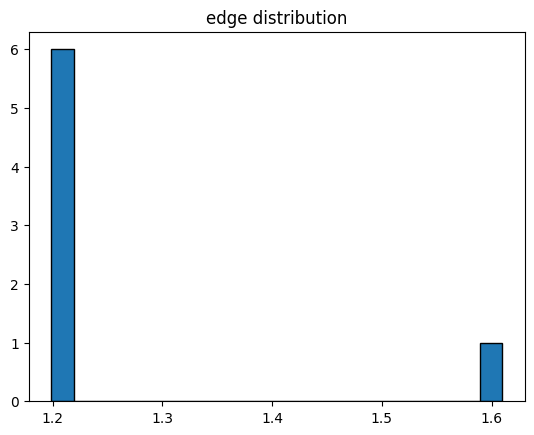

In [17]:
plt.hist(edge_df['edge'] * 100, bins=20, edgecolor='black')
plt.title("edge distribution")
plt.show()

In [18]:
def compute_hitting_prob(row, sl, tp):
    """ 
    Assuming biased or unbiased random walk based on the fraction of previous month's
    up / total step count 
    """
    prob = row['devig_prob']
    rv = prob
    if (prob >= 0.4) & (prob <= 0.6):
        rv = (prob - sl) / (tp - sl)
        return rv
    elif (prob >=0.3) & (prob < 0.4):
        p = 0.35
        q = 0.65
    elif (prob >= 0.2) & (prob < 0.3):
        p = 0.3
        q = 0.7
    elif (prob >= 0.10) & (prob < 0.2):
        p = 0.25
        q = 0.75
    elif (prob > 0.6) & (prob <= 0.7):
        p = 0.65
        q = 0.35
    elif (prob > 0.7) & (prob <= 0.8):
        p = 0.7
        q = 0.3
    elif (prob > 0.8) & (prob <= 0.9):
        p = 0.75
        q = 0.25
    rv = (1 - ((q / p) ** (prob - sl))) / (1 - ((q / p) ** (tp - sl)))
    return rv

In [19]:
KELLY_FRAC = 0.25

ev_dict = defaultdict(list)
for i in range(len(edge_df)):
    row = edge_df.iloc[i]
    #entry = row['bid']
    entry = row['ask']
    tp_list = []
    sl_list = []
    temp_tp = row['devig_prob'] + 0.1
    temp_sl = entry - 0.1
    while (temp_tp < 1):
        tp_list.append(temp_tp)
        temp_tp = temp_tp + 0.01
    assert(len(tp_list) != 0)
    while (temp_sl > 0):
        sl_list.append(temp_sl)
        temp_sl = temp_sl - 0.01
    if len(sl_list) == 0:
        sl_list.append(0)
    for tp in tp_list:
        for sl in sl_list:
            if tp <= sl:
                continue
            if not (sl < entry < tp):
                continue
            if not (sl < row['devig_prob'] < tp):
                continue
           
            p = compute_hitting_prob(row, sl, tp)
            #p = (row['devig_prob'] - sl) / (tp - sl)
            kelly = entry * (p * (tp - entry) - (1 - p) * (entry - sl)) / ((tp - entry) * (entry - sl))
            if kelly <= 0:
                continue
            kelly = min(kelly * KELLY_FRAC, 0.1)
            optimal_bet = kelly * BANKROLL
            num_contracts = optimal_bet // entry
            trading_cost_entry = np.ceil(100*(0.0175 * num_contracts * entry * (1 - entry))) / 100
            trading_cost_exit1 = np.ceil(100*(0.0175 * num_contracts * tp * (1 - tp))) / 100
            trading_cost_exit2 = np.ceil(100*(0.0175 * num_contracts * sl * (1 - sl))) / 100
            trading_cost_exit = (trading_cost_exit1 + trading_cost_exit2) / 2
            trading_cost = trading_cost_entry + trading_cost_exit
            profit = num_contracts * (tp - entry)
            loss = num_contracts * (entry - sl)
            ev = profit * p - loss * (1 - p) - trading_cost
            ev_dict[i].append([tp, sl, kelly, optimal_bet, num_contracts, trading_cost, profit, loss, ev, p])
        


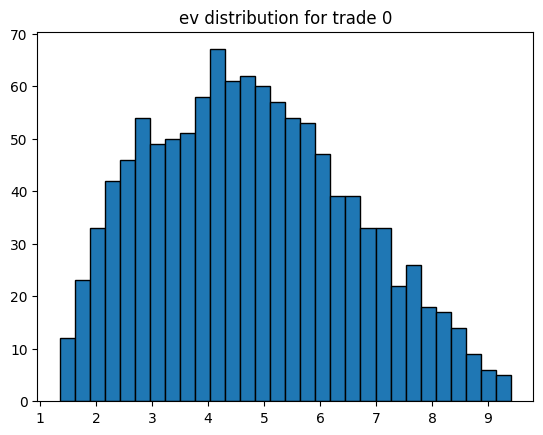

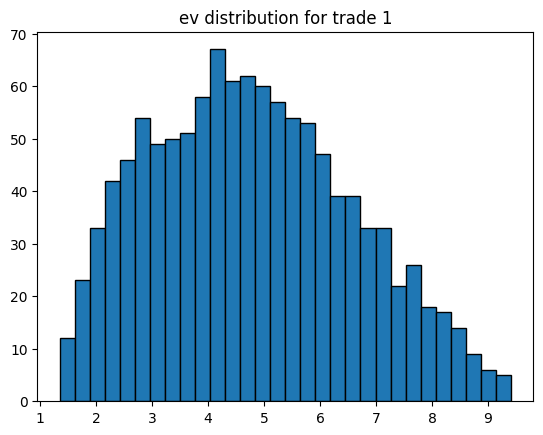

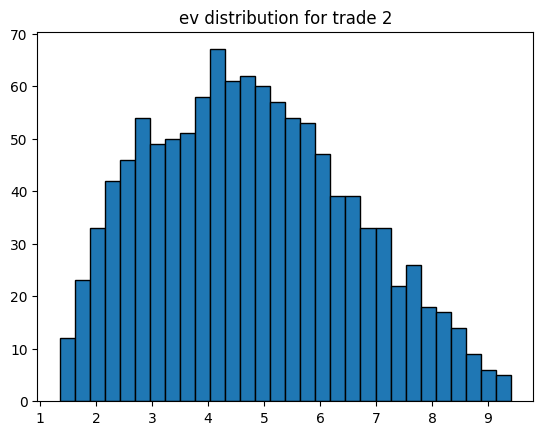

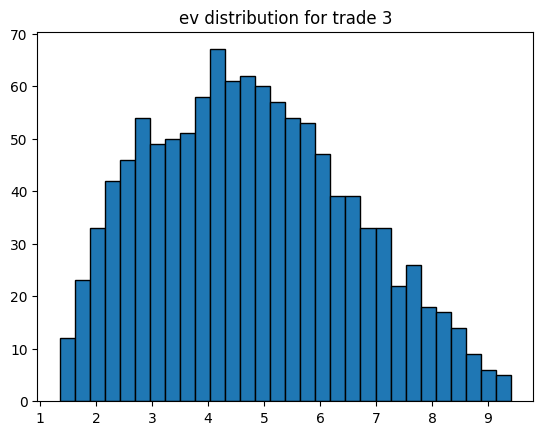

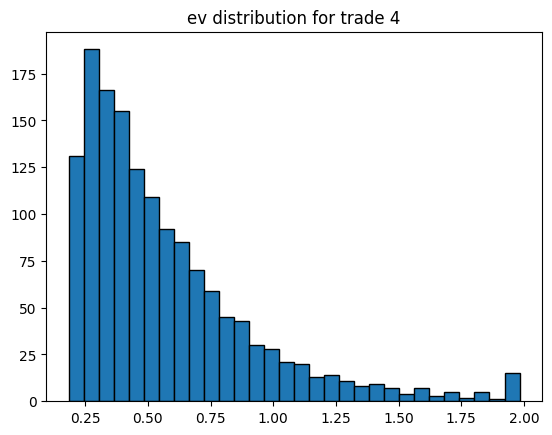

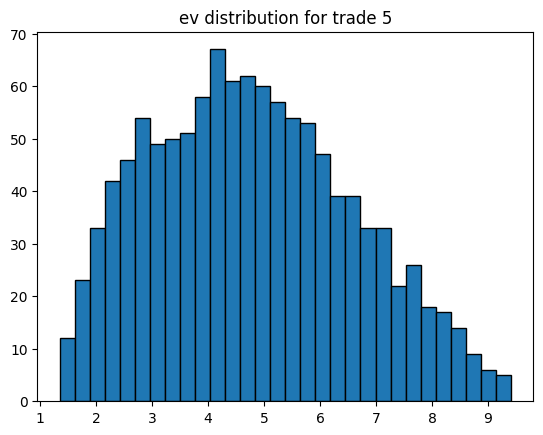

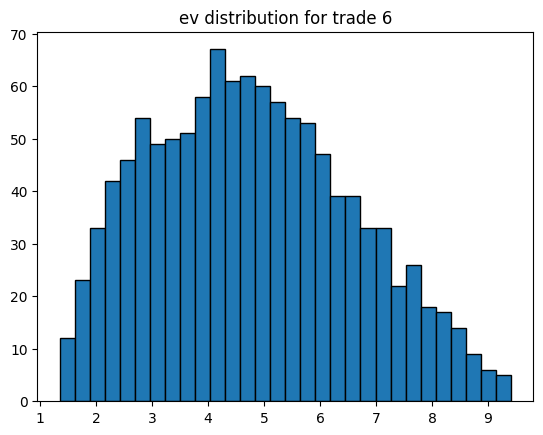

In [20]:
#plots the ev distribution for every trade for different pairs of (tp, sl)
for i in range(len(ev_dict)):
    trade_curr = ev_dict[i] 
    tp_list, sl_list, _, _, _, _, _, _, ev_list, p_list = map(list, zip(*trade_curr))
    plt.hist(ev_list, bins=30, edgecolor='black')
    plt.title(f"ev distribution for trade {i}")
    plt.show()
    

In [21]:
cols = ['tp', 'sl', 'kelly', 'optimal_bet', 'num_contracts', 'trading_cost', 'profit', 'loss', 'ev', 'p']

best_by_key = {
    k: max(trades, key=lambda x: x[8])   
    for k, trades in ev_dict.items()
    if trades
}

best_by_key = {
    k: [round(v[0], 2), round(v[1], 2), *v[2:]]
    for k, v in best_by_key.items()
}

keys = list(best_by_key.keys())
filtered_df = edge_df.iloc[keys].copy()
filtered_df[cols] = np.array([best_by_key[k] for k in keys], dtype=float)
filtered_df = filtered_df.loc[filtered_df['ev'] > 0]



In [22]:
filtered_df.drop(columns=['yes_bid','yes_ask', 'no_bid', 'no_ask', 'midprice'], inplace=True)
filtered_df = filtered_df[['ticker', 'oddsapi_start_time',
       'oddsapi_home_team', 'oddsapi_away_team', 'oddsapi_team', 'ask', 'devig_prob', 'edge', 'buy_direction',
       'tp', 'sl', 'p', 'kelly', 'optimal_bet', 'num_contracts', 'trading_cost',
       'profit', 'loss', 'ev']]
filtered_df.rename(columns={"p": "p_hit"}, inplace=True)
filtered_df['edge'] = filtered_df['edge'] * 100
filtered_df[['kelly', 'profit', 'ev', 'optimal_bet']] = filtered_df[['kelly', 'profit', 'ev', 'optimal_bet']].round(2)
filtered_df[['devig_prob', 'p_hit']] = filtered_df[['devig_prob', 'p_hit']].round(4) * 100


s = filtered_df['oddsapi_start_time'].astype(str)
s = s.str.replace(r'\s+[A-Z]{3}$', '', regex=True)
dt = pd.to_datetime(s, errors='coerce')

now = datetime.now(pytz.timezone('America/Chicago'))
#filtered_df = filtered_df.loc[filtered_df['oddsapi_start_time'] > now].sort_values('oddsapi_home_team').reset_index(drop=True)

filtered_df.drop(columns=['oddsapi_start_time'], inplace=True)

In [23]:
filtered_df 

,ticker,oddsapi_home_team,oddsapi_away_team,oddsapi_team,ask,devig_prob,edge,buy_direction,tp,sl,p_hit,kelly,optimal_bet,num_contracts,trading_cost,profit,loss,ev
0,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Cornell Big Red,Princeton Tigers,Princeton Tigers,0.7,71.20,1.198706,no,0.99,0.01,79.37,0.08,77.67,110.0,0.430,32.12,75.90,9.41
1,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Cornell Big Red,Princeton Tigers,Princeton Tigers,0.7,71.20,1.198706,no,0.99,0.01,79.37,0.08,77.67,110.0,0.430,32.12,75.90,9.41
2,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Cornell Big Red,Princeton Tigers,Princeton Tigers,0.7,71.20,1.198706,no,0.99,0.01,79.37,0.08,77.67,110.0,0.430,32.12,75.90,9.41
3,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Cornell Big Red,Princeton Tigers,Princeton Tigers,0.7,71.20,1.198706,no,0.99,0.01,79.37,0.08,77.67,110.0,0.430,32.12,75.90,9.41
4,KXNCAAMBGAME-26JAN30FAIRIONA-IONA,Iona Gaels,Fairfield Stags,Iona Gaels,0.4,41.61,1.609578,no,0.52,0.27,59.37,0.10,100.00,249.0,2.025,28.91,32.37,1.98
5,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Cornell Big Red,Princeton Tigers,Princeton Tigers,0.7,71.20,1.198706,no,0.99,0.01,79.37,0.08,77.67,110.0,0.430,32.12,75.90,9.41
6,KXNCAAMBGAME-26JAN30PRINCOR-PRIN,Cornell Big Red,Princeton Tigers,Princeton Tigers,0.7,71.20,1.198706,no,0.99,0.01,79.37,0.08,77.67,110.0,0.430,32.12,75.90,9.41


In [24]:
total_loss = np.sum(filtered_df['loss'])
total_profit = np.sum(filtered_df['profit'])
total_ev = np.sum(filtered_df['ev'])
print(f"{sport} h2h portfolio summary:\n")
print(f"Max Loss: -{total_loss:.2f}")
print(f"Max Profit: {total_profit:.2f}")
print(f"Portfolio EV: {total_ev:.2f}")


NCAAMB h2h portfolio summary:

Max Loss: -487.77
Max Profit: 221.63
Portfolio EV: 58.44
